# LIBRARIES

In [1]:
#------------------------------------------------------------------- LIBRARIES
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasgui import show
import nltk
from collections import Counter
import re


pd.set_option('display.max_columns', None)  # To display all columns
pd.set_option('display.max_rows', None)     # To display all rows

#------------------------------------------------------------------- PATHS

results_end_customer_path = 'Input/Results End Customer POS.xlsx'
key_accounts_path = 'Input/key_account_list_total.csv'
geography_path = 'Input/Geography.xlsx'



# LOAD DATA

Import data from Results End Customer POS, Key Accounts and Geography files.

In [2]:
#------------------------------------------------------------------- LOAD DATA
def read_results_end_customer():
    df_results = pd.read_excel(results_end_customer_path, usecols=['id_sk_tax', 
                                                                   'code_country', 
                                                                   'desc_end_customer'], 
                                                                   dtype=str)
    
    # ERROR DEBUGGING
    #df_results = df_results[df_results['code_country'].str.upper() == 'FR']

    # SAMPLE
    #df_results = df_results.sample(n=15000)
    
    geography = pd.read_excel(geography_path, usecols=['code_country', 'desc_country'], dtype=str)
    geography.drop_duplicates(inplace=True)
    geography['code_country'] = geography['code_country'].str.strip().str.upper()
    geography['desc_country'] = geography['desc_country'].str.strip().str.upper()

    df_results['code_country'] = df_results['code_country'].map(dict(zip(geography['code_country'], geography['desc_country'])))
    
    return df_results

def read_ka():
    """
    Read key account total (Key names + SFDC customers)
    """
    try:
        df_ka = pd.read_csv(key_accounts_path, encoding="utf-8")
    
    except UnicodeDecodeError:
        df_ka = pd.read_csv(key_accounts_path, encoding="ISO-8859-1")

    df_ka['Key Account'] = df_ka['Key Account'].astype(str).apply(lambda x: x.replace("�", "ä"))
    df_ka['Country'] = df_ka['Country'].str.strip().str.upper()
    return df_ka

# data frames
df_results_end_customer = read_results_end_customer()
df_key_accounts = read_ka()

In [ ]:
#------------------------------------------------------------------- WORD FREQUENCY LISTS FOR COUNTRIES
nltk.download('punkt')

# tokenize the 'desc_end_customer' column for every country
df_results_end_customer['desc_end_customer'] = df_results_end_customer['desc_end_customer'].fillna('')
df_results_end_customer['tokens'] = df_results_end_customer['desc_end_customer'].apply(nltk.word_tokenize)

# create the dictionary of word frequencies for every country
country_word_lists = {}

# grpuop by country and calcualte word frequency for every country
for country, group in df_results_end_customer.groupby('code_country'):
    country_tokens = {token.lower() for tokens in group['tokens'] for token in tokens}
    country_tokens_counts = Counter(country_tokens)

    country_word_lists[country] = [word for word, _ in country_tokens_counts.most_common(30)]

for country, common_words_list in country_word_lists.items():
    print(f"Top 20 common words for {country}:")
    print(common_words_list)
    print("\n")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JuliánAuxMillán_KCC\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package punkt is already up-to-date!


Top 20 common words for AUSTRIA:
['bk', 'stiger', 'kg', 'ludwigstorff', 'electric', 'juszt', 'hainzl', 'see', '035', 'beschriftungsdesign', 'charme', 'exploration', 'versammlung', 'und', 'barmherzige', 'p', 'progros', 'rathaus', 'magdas', 'traffic', 'betriebsgesellschaft', 'ait', 'i', 'wissenschafte', 'sappho', 'kanadische', 'ckv', 'schuster', 'reinigungsbedarf', 'messe']


Top 20 common words for BELGIUM:
['rpl', 'xx', 'chene', 'mittal', 'belourthe', 'frites', 'total', 'bonten', 'want', 'glocal', 'chapellelezherlaimont', 'berenbaum', 'i', 'vkg', 'compostella', '4000', 'zonnebloem', 'kids', 'wemmet', 'flexibles', 'balta', 'emma', 'gezondheidscentrum', 'clb', 'ferme', '222', 'woonzorggroep', 'oiw', 'ever', 'branch']


Top 20 common words for BULGARIA:
['labimex']


Top 20 common words for CAMEROON:
['cameroon', 'convention', 'baptist']


Top 20 common words for CROATIA:
['o', 'd', 'selvita', 'biovit']


Top 20 common words for CZECH REPUBLIC:
['vladislava', 'safran', 'artifex', 'orea', 

# HISTOGRAMS    

These histograms help to see the words with most frequency in every country

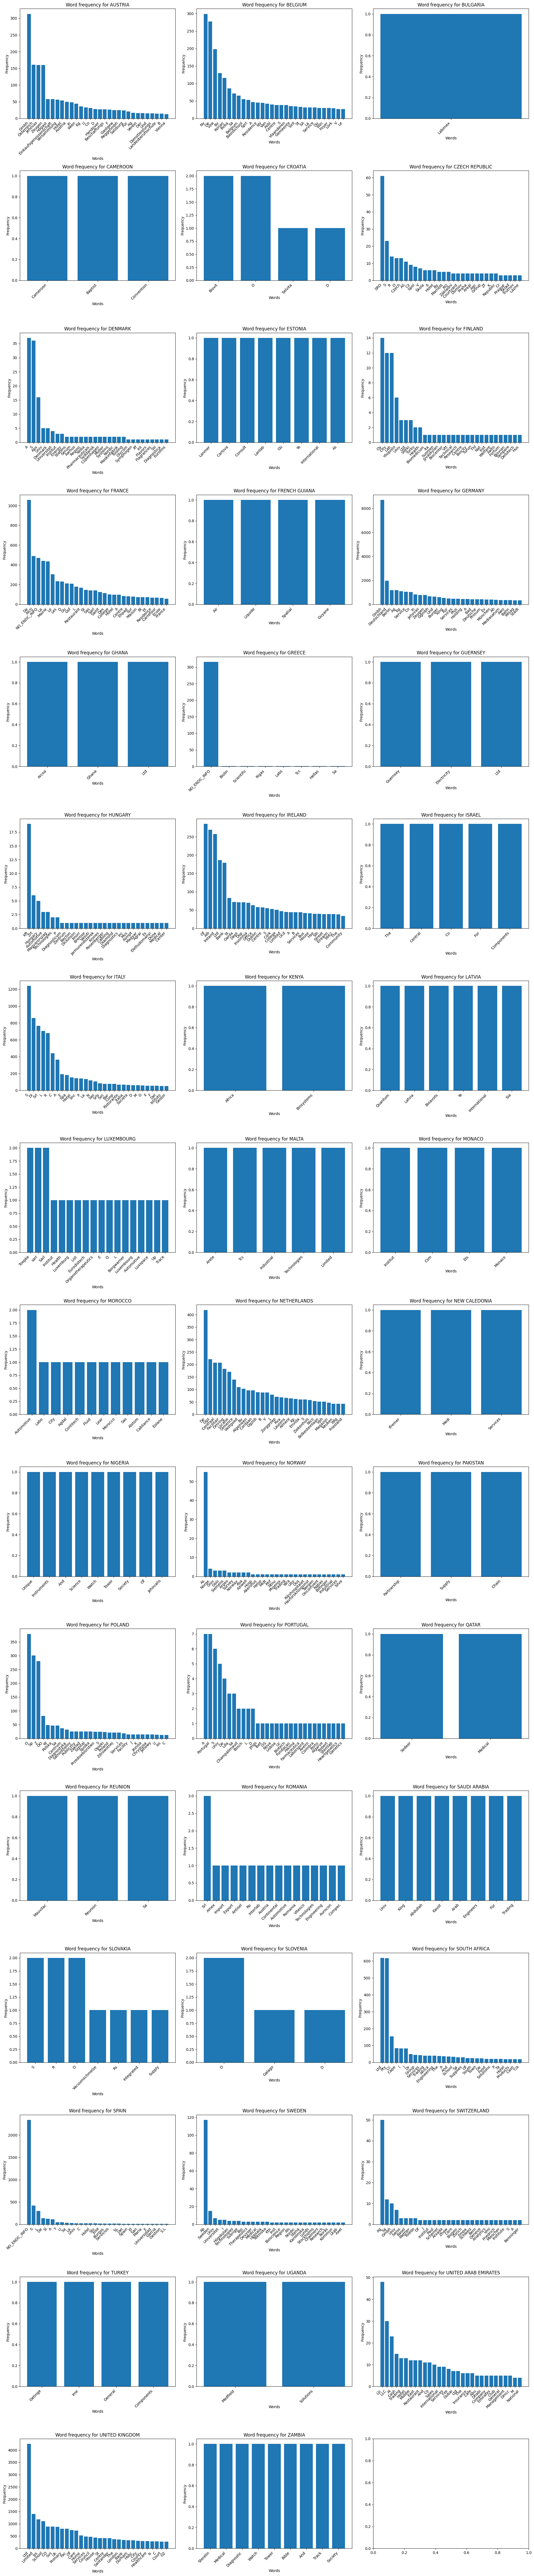

In [3]:
# ----------------------------------------------------------------------------------------- HISTOGRAM WORDS FREQUENCY FOR COUNTRIES

# tokenize the 'desc_end_customer' column for every country
df_results_end_customer['desc_end_customer'] = df_results_end_customer['desc_end_customer'].fillna('')
df_results_end_customer['tokens'] = df_results_end_customer['desc_end_customer'].apply(nltk.word_tokenize)

# create the dictionary of word frequencies for every country
country_word_counts = {}

# create the figure for plotting multiple histograms
num_countries = len(df_results_end_customer['code_country'].unique())
num_rows = (num_countries + 1) // 3         # ensure two plots per row

fig, axes = plt.subplots(num_rows, 3, figsize=(20, num_rows*6))

# flatten axes array to make indexing easier
axes = axes.flatten()

# grpuop by country and calcualte word frequency for every country
for idx, (country, group) in enumerate(df_results_end_customer.groupby('code_country')):
    country_tokens = [token for tokens in group['tokens'] for token in tokens]
    country_tokens_counts = Counter(country_tokens)

    country_word_counts[country] = country_tokens_counts.most_common(30)

    # plot the histogram
    words, frequencies = zip(*country_word_counts[country])

    axes[idx].bar(words, frequencies)
    axes[idx].set_xticks(range(len(words)))
    axes[idx].set_xticklabels(words, rotation=45, ha='right')
    axes[idx].set_title(f"Word frequency for {country}")
    axes[idx].set_xlabel("Words")
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## HISTOGRAM FUNCTION

This function is to make histograms according to the country

In [22]:
def plot_histogram(df: pd.DataFrame , country_code: str, column_name: str, top_n):
    """
    Creates and plots a histogram of the most common words for a specific country.

    Args:
    - df: DataFrame containing the data
    - country: str, the country code for which to plot the histogram
    - column_name: str, The column containing the customer description (default is 'desc_end_customer').
    - top_n: int, The number of most common words to plot (default is 20).

    Returns:
    - A histogram plot.
    """
    country_data = df[df['code_country'] == country_code]

    # tokenize the description for the specific country
    country_data['tokens'] = country_data[column_name].apply(nltk.word_tokenize)

    # flatten the list of tokens for the specific country
    all_tokens = [token.lower() for tokens in country_data['tokens'] for token in tokens]

    # count the frequency of each word
    word_counts = Counter(all_tokens)

    # get the most common words (top_n)
    common_words = word_counts.most_common(top_n)

    # separate the words and their frequencies
    words, frequencies = zip(*common_words)

    # plot the histogram
    plt.figure(figsize=(12, 6))
    bars = plt.bar(words, frequencies)
    plt.xticks(rotation=45, ha='right')

    # frequenct count as labels above the bars
    for bar, frequency in zip(bars, frequencies):
        plt.text(
            bar.get_x() + bar.get_width() /2,        # position the text at the center
            bar.get_height(),
            str(frequency),
            ha='center',
            va='bottom',
            fontsize=8
        )
        
    plt.title(f"Top {top_n} Common Words in {country_code}")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


# TEXT CLEANING 

The idea is:
1. Join the letters like S R L to SRL.
2. Join the letters that are separated with a space ' ' after to fix the legal suffixes.
3. Remove the words SRL cause those words are legal sufixes.

## REPLACE LEGAL SUFFIXES FUNCTIONS

In [18]:
def replace_legal_suffixes(text):
    legal_suffixes = {
        'S C A R L': 'SCARL', 'Scarl': 'SCARL', 'A R L': 'ARL', 'A r l': 'ARL', 'Arl': 'ARL', 
        'S R L': 'SRL', 'S r l': 'SRL', 'Srl': 'SRL', 'S P A': 'SPA', 'S p a': 'SPA', 'Spa': 'SPA', 
        'S A S': 'SAS', 'Sas': 'SAS', 'S A': 'SA', 'Sa': 'SA', 'S N C': 'SNC', 'Snc': 'SNC', 
        'S A P A': 'SAPA', 'Sapa': 'SAPA', 'S C R L': 'SCRL', 'Scrl': 'SCRL', 'S R L S': 'SRLS', 
        'Srls': 'SRLS', 'S C A': 'SCA', 'Sca': 'SCA', 'S C': 'SC', 'Sc': 'SC', 'S O C': 'SOC', 
        'Soc': 'SOC', 'C O O P': 'COOP', 'Coop': 'COOP', 'S RO': 'SRO', 'S R O': 'SRO', 'Sro': 'SRO',
    }
    for old_suffix, new_suffix in legal_suffixes.items():
        text = re.sub(r'\b' + re.escape(old_suffix) + r'\b', new_suffix, text, flags=re.IGNORECASE)             # use reges to replace the suffixe (case insensitive)
    return text

## JOIN LETTERS FUNCTION

In [ ]:
# --------------------------------- JOIN LETTERS
def join_letters(text):
    text = re.sub(r'\b([A-Z])\s+([A-Z])\s+([A-Z])\s+([A-Z])\s+([A-Z])\s+([A-Z])\s+([A-Z])\s+([A-Z])\b', r'\1\2\3\4\5\6\7\8', text)  # For 8 uppercase letters
    text = re.sub(r'\b([A-Z])\s+([A-Z])\s+([A-Z])\s+([A-Z])\s+([A-Z])\s+([A-Z])\s+([A-Z])\b', r'\1\2\3\4\5\6\7', text)              # For 7 uppercase letters
    text = re.sub(r'\b([A-Z])\s+([A-Z])\s+([A-Z])\s+([A-Z])\s+([A-Z])\s+([A-Z])\b', r'\1\2\3\4\5\6', text)                          # For 6 uppercase letters
    text = re.sub(r'\b([A-Z])\s+([A-Z])\s+([A-Z])\s+([A-Z])\s+([A-Z])\b', r'\1\2\3\4\5', text)                                      # For 5 uppercase letters
    text = re.sub(r'\b([A-Z])\s+([A-Z])\s+([A-Z])\s+([A-Z])\b', r'\1\2\3\4', text)                                                  # For 4 uppercase letters
    text = re.sub(r'\b([A-Z])\s+([A-Z])\s+([A-Z])\b', r'\1\2\3', text)                                                              # For 3 uppercase letters
    text = re.sub(r'\b([A-Z])\s+([A-Z])\b', r'\1\2', text)                                                                          # For 2 uppercase letters

    # repeat for any higher count, or use a simple pattern to match any space-separated capital letters
    text = re.sub(r'\b([A-Z])\s+([A-Z])\s+([A-Z])\b', r'\1\2\3', text) 
    
    return text



## ITALY

It will be fix the information for Italy

In [14]:
# ----- explore the data for Italy
italy_data = df_results_end_customer[df_results_end_customer['code_country'] == 'ITALY']

# apply the function to replace the legal suffixes
italy_data['desc_end_customer'] = italy_data['desc_end_customer'].apply(replace_legal_suffixes)

C:\Users\JuliánAuxMillán_KCC\AppData\Local\Temp\ipykernel_27920\3829347963.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  italy_data['desc_end_customer'] = italy_data['desc_end_customer'].apply(replace_legal_suffixes)


In [16]:
# Apply the function to join the letters
italy_data['correcion'] = italy_data['desc_end_customer'].apply(join_letters)

C:\Users\JuliánAuxMillán_KCC\AppData\Local\Temp\ipykernel_27920\3396583334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  italy_data['correcion'] = italy_data['desc_end_customer'].apply(join_letters)


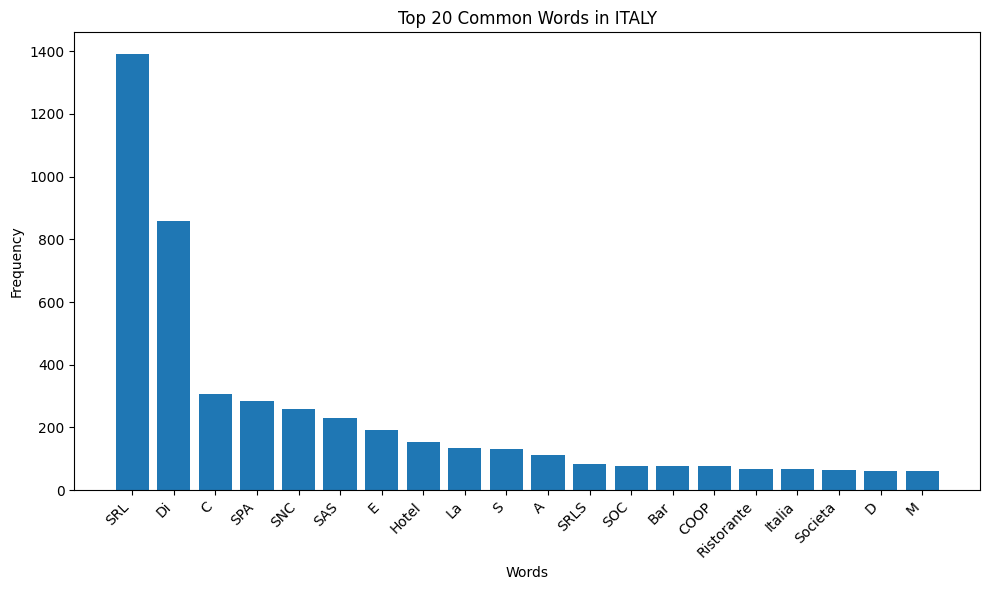

In [41]:
# Histogram plot for Italy
plot_histogram(italy_data, 'ITALY', 'desc_end_customer', top_n=20)

## BELGIUM

In [17]:
belgium = df_results_end_customer[df_results_end_customer['code_country'] == 'BELGIUM']
#belgium['correcion'] = belgium['desc_end_customer'].apply(join_letters)

#plot_histogram(belgium, 'BELGIUM', 'correcion', top_n=40)

## CZECH REPUBLIC


In [37]:
czech_republic = df_results_end_customer[df_results_end_customer['code_country'] == 'CZECH REPUBLIC']

# apply the function to replace the legal suffixes
czech_republic['desc_end_customer'] = czech_republic['desc_end_customer'].apply(replace_legal_suffixes)

# apply the function to join the letters
czech_republic['desc_end_customer'] = czech_republic['desc_end_customer'].apply(join_letters)


C:\Users\JuliánAuxMillán_KCC\AppData\Local\Temp\ipykernel_27920\4068001534.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  czech_republic['desc_end_customer'] = czech_republic['desc_end_customer'].apply(replace_legal_suffixes)
C:\Users\JuliánAuxMillán_KCC\AppData\Local\Temp\ipykernel_27920\4068001534.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  czech_republic['desc_end_customer'] = czech_republic['desc_end_customer'].apply(join_letters)


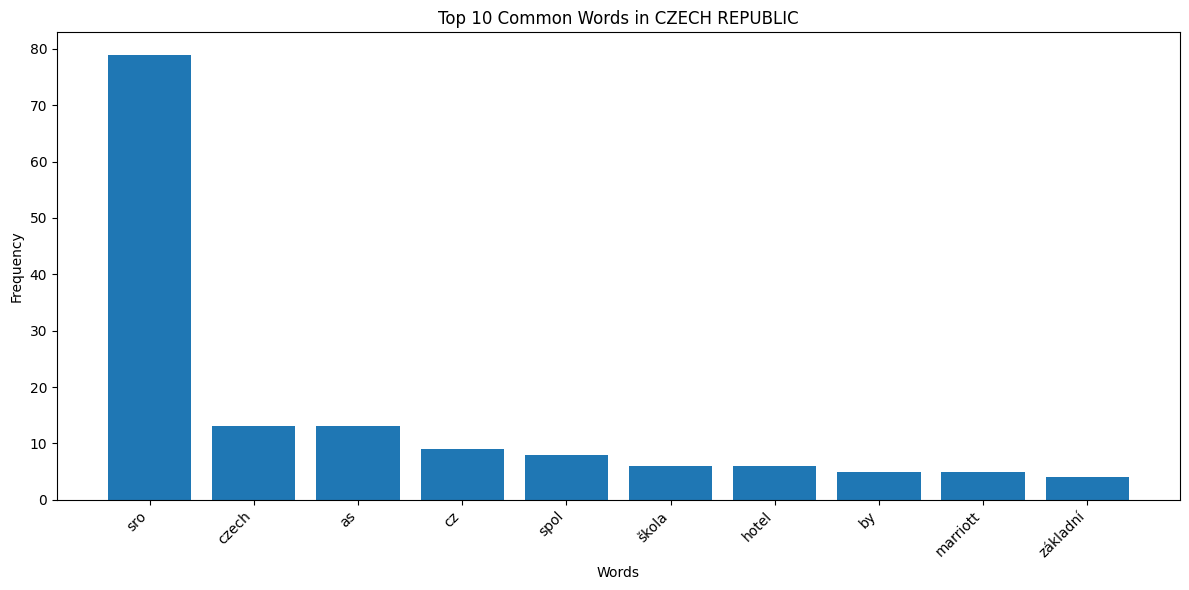

In [42]:
# plot the histogram for the Czech Republic
plot_histogram(czech_republic, 'CZECH REPUBLIC', 'desc_end_customer', 10)

## DENMARK

C:\Users\JuliánAuxMillán_KCC\AppData\Local\Temp\ipykernel_27920\3593934653.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  denmark['correcion'] = denmark['desc_end_customer'].apply(join_letters)


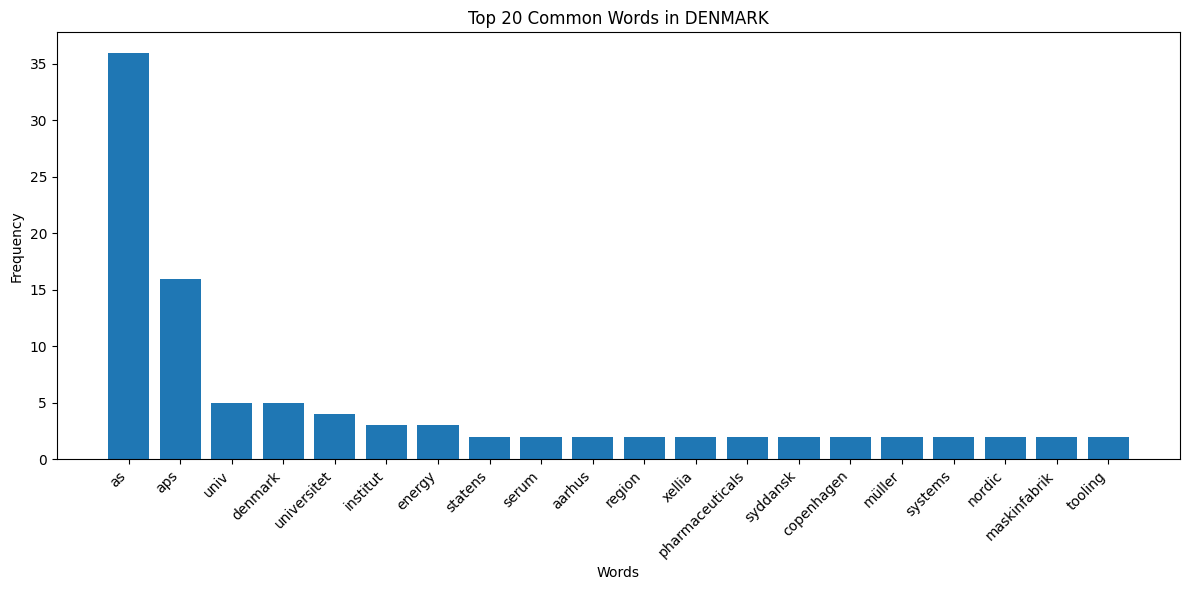

In [45]:
denmark = df_results_end_customer[df_results_end_customer['code_country'] == 'DENMARK']

# apply the function to join the letters
denmark['correcion'] = denmark['desc_end_customer'].apply(join_letters)

# plot the histogram for Denmark
plot_histogram(denmark, 'DENMARK', 'correcion', 20)

## FINLAND

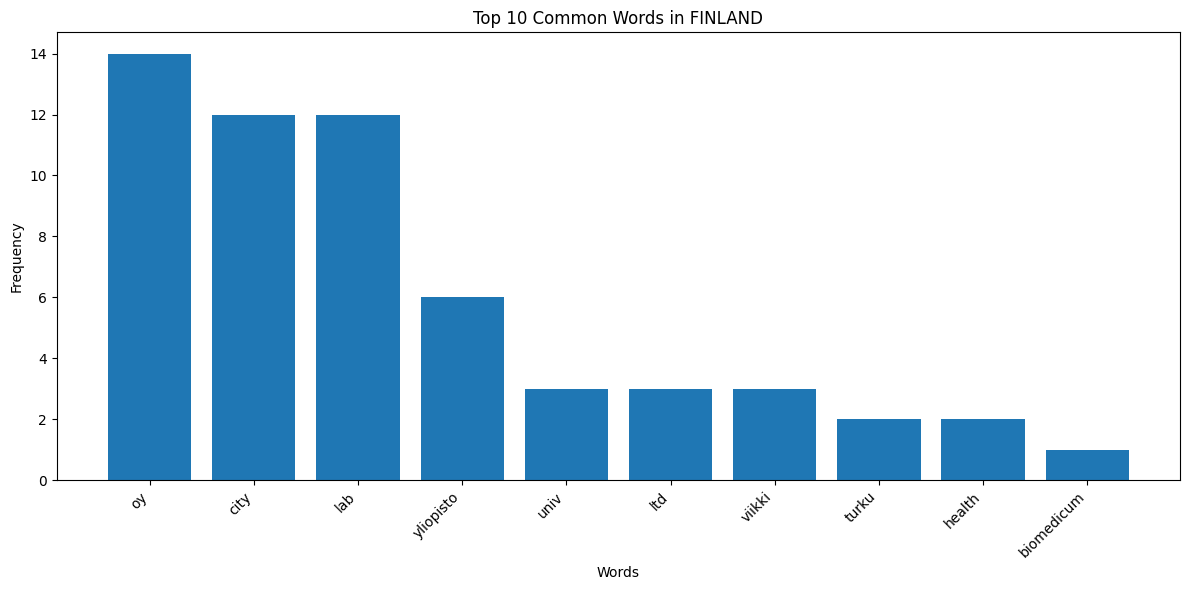

In [48]:
finland = df_results_end_customer[df_results_end_customer['code_country'] == 'FINLAND']

# plot the histogram for Finland
plot_histogram(finland, 'FINLAND', 'desc_end_customer', 10)

## FRANCE

C:\Users\JuliánAuxMillán_KCC\AppData\Local\Temp\ipykernel_12060\3125148570.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  france['correcion'] = df_results_end_customer['desc_end_customer'].apply(join_letters)
C:\Users\JuliánAuxMillán_KCC\AppData\Local\Temp\ipykernel_12060\3543221406.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['tokens'] = country_data[column_name].apply(nltk.word_tokenize)


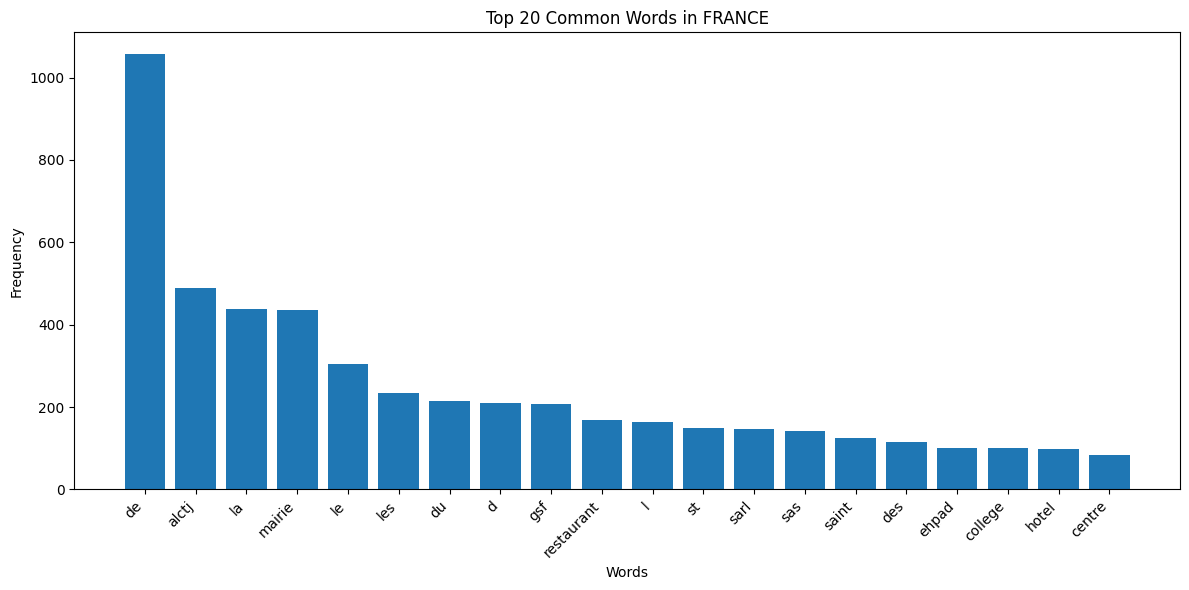

In [11]:
france = df_results_end_customer[df_results_end_customer['code_country'] == 'FRANCE']
france = df_results_end_customer[df_results_end_customer['desc_end_customer'] != 'NO_ENDC_INFO']

# apply the function to join the letters
france['correcion'] = df_results_end_customer['desc_end_customer'].apply(join_letters)

# plot the histogram for France
plot_histogram(france, 'FRANCE', 'correcion', 20)


## GERMANY

In [ ]:
germany = df_results_end_customer[df_results_end_customer['code_country'] == 'GERMANY']

# apply the join letters function
germany['correcion'] = df_results_end_customer['desc_end_customer'].apply(join_letters)

C:\Users\JuliánAuxMillán_KCC\AppData\Local\Temp\ipykernel_12060\603187692.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  germany['correcion'] = df_results_end_customer['desc_end_customer'].apply(join_letters)


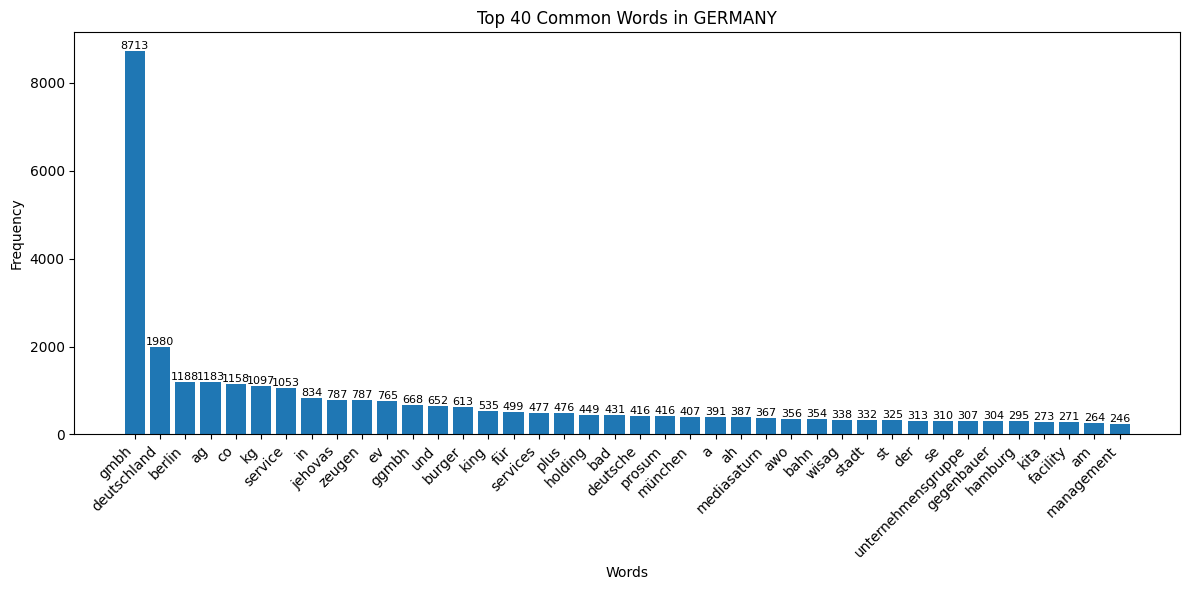

In [23]:
# plot the histogram for Germany
plot_histogram(germany, 'GERMANY', 'correcion', 40)

## IRELAND

In [25]:
ireland = df_results_end_customer[df_results_end_customer['code_country'] == 'IRELAND']
ireland['desc_end_customer'] = df_results_end_customer['desc_end_customer'].apply(join_letters)

C:\Users\JuliánAuxMillán_KCC\AppData\Local\Temp\ipykernel_12060\1198788588.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ireland['desc_end_customer'] = df_results_end_customer['desc_end_customer'].apply(join_letters)


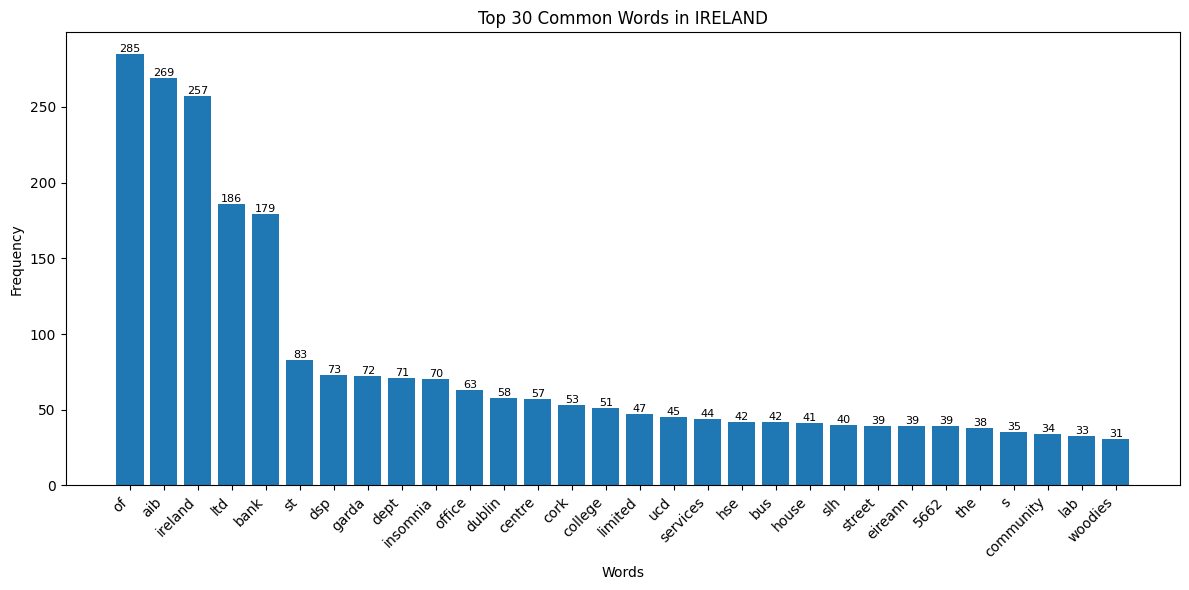

In [27]:
plot_histogram(ireland, 'IRELAND', 'desc_end_customer', 30)

# CLEAN RESULTS END CUSTOMERS DATASET

In [31]:
results_end_customer = df_results_end_customer.copy()

## APPLY CLEANING FUNCTIONS

The cleaning functions is for:
+ Special characters removing
+ Accents removing
+ Join letters

### FUNCTIONS

In [37]:
def clean_special_chars(df, column):
    """
    Removes special characters from a given column in a DataFrame.
    """
    special_charac=r'[\'~@#¿?¡!%&*()_+\-==\[\]{};\'\\:"|<>,./]'
    df[column]=df[column].replace({special_charac:' '}, regex=True)
    df[column] = df[column].str.lower().str.strip()
    return df

def remove_accents(text):
    import unicodedata
    """
    Removes accents from a given text.
    """
    # Normalice the text and remove the diacritical marks (accents, tildes, etc.)
    normalized_text = ''.join((c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn'))
    
    # Replace "ß" by "ss" 
    normalized_text = normalized_text.replace("ß", "ss")
    
    return normalized_text

def process_column(df, column):
    # remove special characters
    df = clean_special_chars(df, column)

    # remove accents
    df[column] = df[column].apply(remove_accents)

    # join letters
    df[column] = df[column].apply(join_letters)

    return df

In [32]:
results_end_customer['desc_end_customer'] = results_end_customer['desc_end_customer'].apply(join_letters)

Histogram for each country

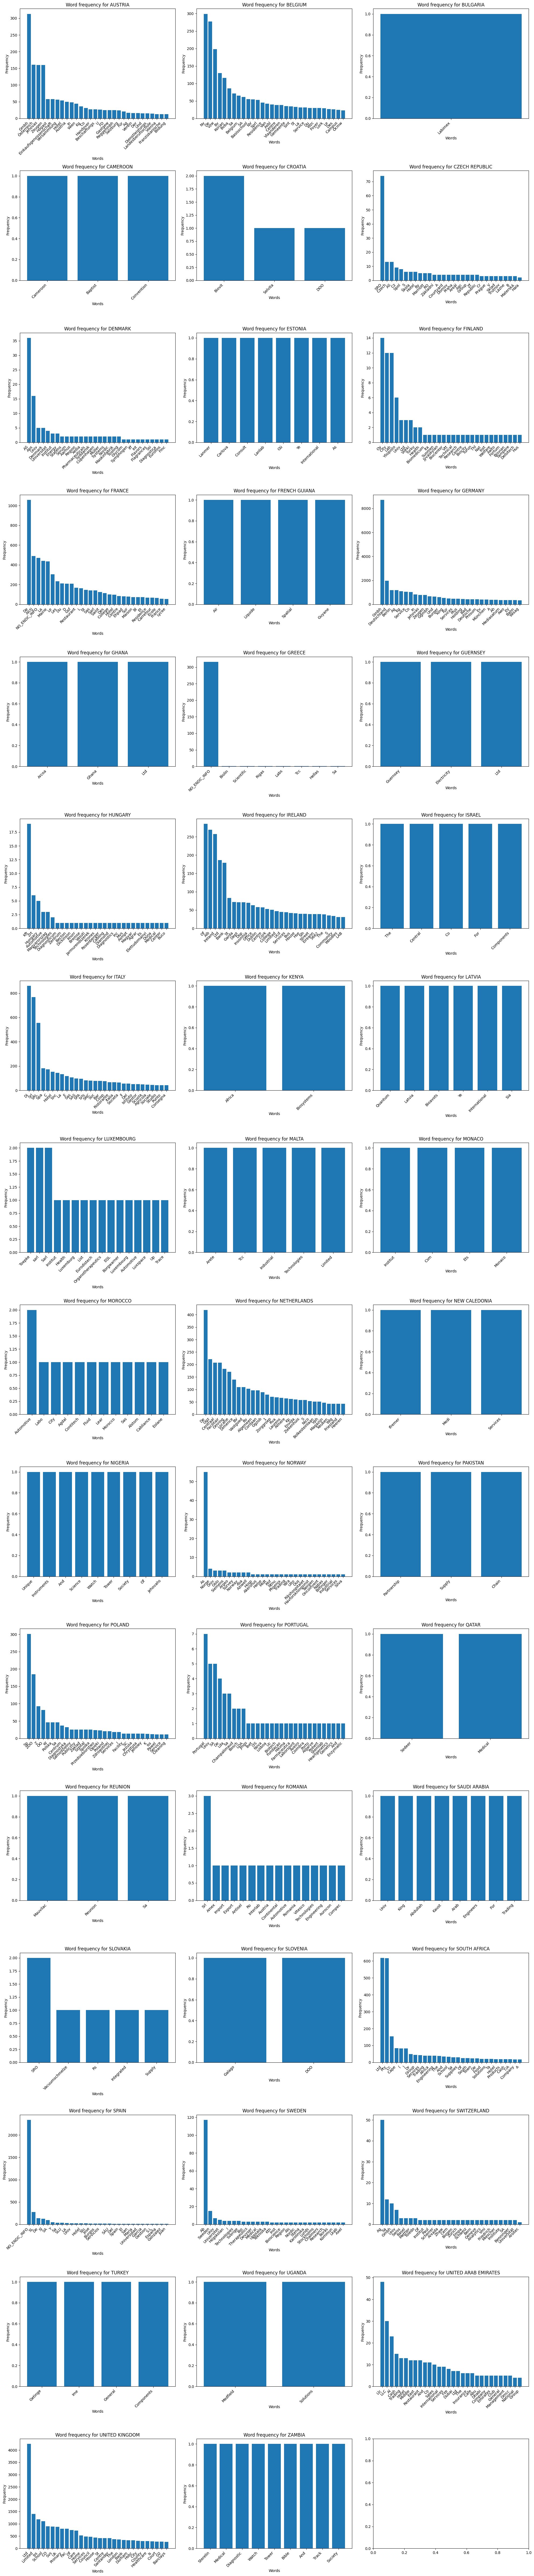

In [33]:
# tokenize the 'desc_end_customer' column for every country
results_end_customer['desc_end_customer'] = results_end_customer['desc_end_customer'].fillna('')
results_end_customer['tokens'] = results_end_customer['desc_end_customer'].apply(nltk.word_tokenize)

# create the dictionary of word frequencies for every country
country_word_counts = {}

# create the figure for plotting multiple histograms
num_countries = len(results_end_customer['code_country'].unique())
num_rows = (num_countries + 1) // 3         # ensure two plots per row

fig, axes = plt.subplots(num_rows, 3, figsize=(20, num_rows*6))

# flatten axes array to make indexing easier
axes = axes.flatten()

# grpuop by country and calcualte word frequency for every country
for idx, (country, group) in enumerate(results_end_customer.groupby('code_country')):
    country_tokens = [token for tokens in group['tokens'] for token in tokens]
    country_tokens_counts = Counter(country_tokens)

    country_word_counts[country] = country_tokens_counts.most_common(30)

    # plot the histogram
    words, frequencies = zip(*country_word_counts[country])

    axes[idx].bar(words, frequencies)
    axes[idx].set_xticks(range(len(words)))
    axes[idx].set_xticklabels(words, rotation=45, ha='right')
    axes[idx].set_title(f"Word frequency for {country}")
    axes[idx].set_xlabel("Words")
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## DICTIONARIES CREATIONS

It will be created  dictinaries for every country, the dictionary contains the most common words for each country and each dictionary will be saved in the folder 'Histrogram_by_country'

HISTOGRAMS FOR EACH COUNTRY

In [ ]:
base_dir = os.getcwd()
output_dir = os.path.join(base_dir, 'Histogram_by_country')

for country_code, group in df_results_end_customer.groupby('code_country'):
    cleaned_data = process_column(group.copy(), 'desc_end_customer')

    country_tokens = [token for tokens in cleaned_data['desc_end_customer'].apply(nltk.word_tokenize) for token in tokens]
    word_counts = Counter(country_tokens)
    common_words = word_counts.most_common(40)

    common_words_df = pd.DataFrame(common_words, columns=['word', 'quantity'])
    common_words_df = common_words_df.sort_values(by='quantity', ascending=False)

    file_path = os.path.join(output_dir, f'{country_code}.csv')

    common_words_df.to_csv(file_path, index=False)
    
    print(f'done for {country_code}')

DICTIONARIES FOR EACH COUNTRIES

In [ ]:
import json
nltk.download('punkt')
base_dir = os.getcwd()
output_dir = os.path.join(base_dir, 'Banned_word_dictionary')

for country_code, group in df_results_end_customer.groupby('code_country'):
    cleaned_data = process_column(group.copy(), 'desc_end_customer')

    country_tokens = [token for tokens in cleaned_data['desc_end_customer'].apply(nltk.word_tokenize) for token in tokens]
    word_counts = Counter(country_tokens)
    common_words = word_counts.most_common(40)

    country_word = {
        "remove": [word for word, _ in common_words]            # only the words, no the frequencies
    }

    file_path = os.path.join(output_dir, f'{country_code}.json')

    # data in JSON file
    with open(file_path, 'w') as json_file:
        json.dump(country_word, json_file, indent=4)

    print(f'done for {country_code}')

In [52]:
"""
This module performs the text cleaning in the following way:
    -   Remove special characters.
    -   Apply join_letters funtion: after removing the special characters, this function helps to join the single letters.
    -   Remove the commercial words and legal suffixes.
    -   Remove stopwords.
    -   Remove accents.
"""
import re
import unicodedata
import nltk
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import json
import os

# Ensure stopwords are downloaded
nltk.download('punkt')
nltk.download('stopwords')
print('\nStopwords are downloaded \n')

# Load the stopwords for 7 languages
stopwords_es = set(stopwords.words('spanish'))
stopwords_en = set(stopwords.words('english'))
stopwords_fr = set(stopwords.words('french'))
stopwords_de = set(stopwords.words('german'))
stopwords_it = set(stopwords.words('italian'))
stopwords_pt = set(stopwords.words('portuguese'))
stopwords_ru = set(stopwords.words('russian'))
print('Stopwords have been loaded')
    

# ---------------------------------------  JOIN LETTERS FUNCTION ------------------------------------------------------
def join_letters(text):
    text = re.sub(r'\b([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\b', r'\1\2\3\4\5\6\7\8', text)  # For 8 letters
    text = re.sub(r'\b([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\b', r'\1\2\3\4\5\6\7', text)                 # For 7 letters
    text = re.sub(r'\b([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\b', r'\1\2\3\4\5\6', text)                                # For 6 letters
    text = re.sub(r'\b([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\b', r'\1\2\3\4\5', text)                                               # For 5 letters
    text = re.sub(r'\b([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\b', r'\1\2\3\4', text)                                                              # For 4 letters
    text = re.sub(r'\b([a-zA-Z])\s+([a-zA-Z])\s+([a-zA-Z])\b', r'\1\2\3', text)                                                                             # For 3 letters
    text = re.sub(r'\b([a-zA-Z])\s+([a-zA-Z])\b', r'\1\2', text)                                                                                            # For 2 letters

    # repeat for any higher count, or use a simple pattern to match any space-separated capital letters
    text = re.sub(r'\b([A-Z])\s+([A-Z])\s+([A-Z])\b', r'\1\2\3', text) 
    
    return text                                                                                           

   
# ----------------------------------------- REMOVE COMMERCIAL WORDS AND LEGAL SUFFIXES --------------------------------
# Function to load the dictionaries for each country.
def load_banned_words(country_code):
    """
    Load banned word dictionaries based on the country code.
    Dictionaries come from Banned_word_dictionary.

    Args:
        - country_code: The country code.

    Returns:
        - List of banned words (legal suffixes and commercial words).
    """
    banned_words = set()
    file_path = os.path.join("Banned_word_dictionary", f"{country_code}.json")

    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            banned_words.update(data.get("remove", []))
    
    else:
        print(f'Warning: Dictionary for {country_code} not found.')
    
    return banned_words


def remove_banned_words(text, country_code):
    """
    Remove banned words (legal suffixes and commercial words) from the text based on the country-specific dictionary.
    
    Args:
        - text: The text to be cleaned
        - country_code: The country code to load the appropriate banned words.
    
    Returns:
        - The cleaned text with banned words removed.
    """
    banned_words = load_banned_words(country_code)

    words = text.split()
    cleaned_words = [word for word in words if word not in banned_words]

    return ' '.join(cleaned_words)



# --------------------------------------- REMOVE ACCENTS -----------------------------------------------------------
def remove_accents(text):
    """
    Removes accents from a given text.
    """
    # Normalice the text and remove the diacritical marks (accents, tildes, etc.)
    normalized_text = ''.join((c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn'))
    
    # Replace "ß" by "ss" 
    normalized_text = normalized_text.replace("ß", "ss")
    
    return normalized_text


## -------------------------------------- CLEAN TEXT FUNCTION -------------------------------------------------------
# Compile all the function to clean text

def clean_text(text: str, country_code: str):
    """
    Applues all the text cleaning functions in the correct order:
    1. Removes special characters
    2. Removes common phrases
    3. Merges and removes legal suffixes
    4. Removes stopwords
    5. Removes accents  
    """
   
    if not isinstance(text, str) or pd.isna(text):
        return ""
    
    # remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower().strip()

    text = join_letters(text)
    text = remove_banned_words(text, country_code)
    text = remove_accents(text)

    return text


Stopwords are downloaded 

Stopwords have been loaded


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JuliánAuxMillán_KCC\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JuliánAuxMillán_KCC\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
prueba = clean_text("Bulgari Italia S P A", "ITALY")
print(prueba)

bulgari
